In [1]:
# 导入所需要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as imageio
import albumentations as A

from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

import torch
import timm
import glob
import torchmetrics
import time
import psutil
import os
import seaborn as sns

tqdm.pandas()

# 数据预处理

In [2]:
# 查看数据集的前五行
# ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']要预测的目标列
train = pd.read_csv('/kaggle/input/planttraits2024/train.csv')
train.head()


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X18_mean,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,0.117484,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.389315,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477
2,196639184,14.254504,902.071411,49.642857,17.873655,387.977753,22.807142,107,133,119,...,8.552908,0.395241,2.343153,1130.096731,NaN,NaN,NaN,NaN,NaN,NaN
3,195728812,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,...,1.083629,0.154200,1.155308,1042.686546,0.011692,2.818356,0.110673,0.011334,0.229224,141.857187
4,195251545,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,...,0.657585,10.919966,2.246226,2386.467180,0.006157,1.128000,0.026996,0.553815,0.107092,87.146899


X4_mean:茎比密度(SSD)或木材密度(每茎新鲜体积的茎干质量)
X11_mean:叶面积与叶干质量比（特定叶面积，SLA或1/LMA），通常简称为SLA，是指每茎新鲜体积的茎干质量。
X18_mean:株高
X26_mean:种子干质量
X50_mean:每叶面积叶片氮含量
X3112_mean:叶面积(复叶:叶，不含叶柄或不含叶柄)


In [3]:
# 查看数据的特点
train.describe()

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X18_mean,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
count,5.548900e+04,55489.000000,55489.000000,55489.000000,55489.000000,55489.000000,55489.000000,55489.000000,55489.000000,55489.000000,...,5.548900e+04,5.548900e+04,55489.000000,5.548900e+04,39148.000000,39148.000000,39148.000000,39148.000000,39148.000000,39148.000000
mean,1.714553e+08,14.577142,1058.710939,138.164359,56.727213,518.711405,25.227185,116.895673,140.259205,128.187695,...,1.969902e+04,3.459399e+03,13.528574,3.975552e+05,0.007833,1.073573,16.003476,110.733150,0.075108,453.017146
std,4.087868e+07,7.584290,768.992166,136.409312,31.692061,316.618440,9.151237,17.607857,15.075214,16.030602,...,2.309747e+06,2.471919e+05,1356.480785,9.152463e+07,0.012046,4.098486,881.605417,8361.855750,0.159520,4196.228211
min,2.637500e+04,-13.731130,0.000000,0.000000,0.000000,9.877081,7.658674,29.000000,46.000000,42.000000,...,2.330000e-08,5.500000e-07,0.000097,7.690000e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.658614e+08,9.247916,528.315552,53.000000,29.685472,300.478760,18.800001,106.000000,131.000000,118.000000,...,3.102831e-01,5.613414e-01,1.173489,2.552815e+02,0.003292,0.174866,0.029985,0.042226,0.017207,17.259899
50%,1.915103e+08,15.536692,853.776184,95.500000,50.196312,446.522308,23.681778,118.000000,142.000000,129.000000,...,7.156651e-01,2.519985e+00,1.480060,7.244318e+02,0.004996,0.357821,0.095136,0.238664,0.033162,63.322952
75%,1.951001e+08,20.238457,1352.000000,181.485718,80.811249,690.003845,30.399998,130.000000,150.000000,139.000000,...,3.586311e+00,1.491886e+01,1.926343,2.148630e+03,0.007774,1.092862,0.330147,1.516574,0.082851,226.990400
max,1.967668e+08,30.294445,8392.463867,2448.964355,169.582291,2025.894653,63.657616,194.000000,192.000000,201.000000,...,2.720494e+08,3.106555e+07,159759.897700,2.155911e+10,0.284052,515.672017,63535.386846,739701.798818,9.729029,387491.201058


In [4]:
train.isnull().sum()

id                                                                           0
WORLDCLIM_BIO1_annual_mean_temperature                                       0
WORLDCLIM_BIO12_annual_precipitation                                         0
WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month        0
WORLDCLIM_BIO15_precipitation_seasonality                                    0
                                                                         ...  
X11_sd                                                                   16341
X18_sd                                                                   16341
X26_sd                                                                   16341
X50_sd                                                                   16341
X3112_sd                                                                 16341
Length: 176, dtype: int64

In [5]:
# 查看数据集的前五行
test = pd.read_csv('/kaggle/input/planttraits2024/test.csv')
test.head()


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m03,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12
0,201238668,8.086756,2246.500000,127.321426,20.423418,353.381042,17.535713,80,109,90,...,0.385838,0.389460,0.387536,0.374910,0.363712,0.364623,0.379435,0.388294,0.398887,0.397853
1,202310319,10.844286,495.871429,28.023809,18.738306,786.554382,29.292856,130,155,142,...,0.279171,0.300813,0.332776,0.314386,0.291168,0.280947,0.277623,0.276503,0.271212,0.272672
2,202604412,8.105556,378.328583,39.928570,41.885647,722.071167,34.853809,133,134,139,...,0.392073,0.418509,0.437172,0.453239,0.445230,0.435441,0.432758,0.429839,0.417250,0.394216
3,201353439,7.077679,878.785706,70.428574,37.045235,669.389343,25.150000,103,140,116,...,0.384626,0.313667,0.352311,0.401131,0.513455,0.519174,0.474007,0.469071,0.408466,0.366724
4,195351745,4.790555,2299.366699,150.199997,24.136568,462.887695,22.516666,85,114,98,...,0.515619,0.506952,0.462181,0.397052,0.358262,0.369279,0.414420,0.469002,0.519534,0.521837


In [6]:
# 查看数据的特点
test.describe()

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m03,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12
count,6.545000e+03,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,...,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000
mean,1.930247e+08,13.565744,1058.339104,125.929570,51.638085,542.317973,25.467087,115.637892,141.002903,127.907105,...,0.374341,0.386791,0.393410,0.397236,0.399315,0.395898,0.393781,0.387597,0.378937,0.372905
std,2.601377e+07,7.295813,750.088379,139.210627,30.663688,296.284472,8.424315,18.500107,15.432760,16.717081,...,0.119471,0.123467,0.128634,0.137264,0.137448,0.137287,0.135884,0.129999,0.121263,0.117669
min,1.040495e+06,-10.908333,8.000000,3.566667,5.651237,18.719866,7.725000,44.000000,56.000000,46.000000,...,0.024555,0.022465,0.015992,0.005243,0.008057,0.006664,0.004333,0.012781,0.013120,0.009986
25%,1.971690e+08,8.374963,564.633362,51.928570,26.002605,346.196808,19.654222,104.000000,131.000000,118.000000,...,0.286581,0.296758,0.300443,0.295987,0.297844,0.293414,0.291561,0.291953,0.292901,0.290589
50%,2.008276e+08,14.376865,839.700012,89.607140,44.043266,476.105438,24.289333,117.000000,143.000000,129.000000,...,0.359260,0.374658,0.378144,0.375051,0.378714,0.375422,0.375623,0.370606,0.364082,0.359433
75%,2.022672e+08,18.858631,1327.666626,154.409531,74.721260,723.948975,29.916000,129.000000,152.000000,140.000000,...,0.460342,0.479379,0.491111,0.497005,0.493472,0.486382,0.483449,0.475766,0.463359,0.452274
max,2.030654e+08,28.243513,6760.715332,2401.733398,174.304184,1743.707031,58.549999,160.000000,188.000000,174.000000,...,0.752027,0.774559,0.780773,0.801355,0.839684,0.839229,0.825483,0.803632,0.775951,0.759350


In [7]:
test.isnull().sum()

id                                                                       0
WORLDCLIM_BIO1_annual_mean_temperature                                   0
WORLDCLIM_BIO12_annual_precipitation                                     0
WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month    0
WORLDCLIM_BIO15_precipitation_seasonality                                0
                                                                        ..
VOD_X_1997_2018_multiyear_mean_m08                                       0
VOD_X_1997_2018_multiyear_mean_m09                                       0
VOD_X_1997_2018_multiyear_mean_m10                                       0
VOD_X_1997_2018_multiyear_mean_m11                                       0
VOD_X_1997_2018_multiyear_mean_m12                                       0
Length: 164, dtype: int64

热力图，又名相关系数图。根据热力图中不同方块颜色对应的相关系数的大小，可以判断出变量之间相关性的大小。两个变量之间相关系数的计算公式为:
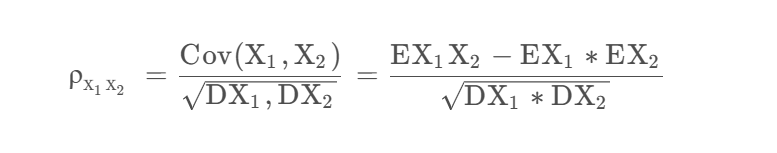

公式中，ρ  表示相关系数，Cov表示协方差,E表示数学期望/均值

值得注意的是，该相关系数只能度量出变量之间的线性相关关系；也就是说，相关系数越高，则变量间的线性相关程度越高。对于相关系数小的两个变量，只能说明变量间的线性相关程度弱，但不能说明变量之间不存在其它的相关关系，如曲线关系等。


In [8]:
train0 = train[['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']]
train0.head()

,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean
0,0.401753,11.758108,0.117484,1.243779,1.849375,50.216034
1,0.480334,15.748846,0.389315,0.642940,1.353468,574.098472
2,0.796917,5.291251,8.552908,0.395241,2.343153,1130.096731
3,0.525236,9.568305,1.083629,0.154200,1.155308,1042.686546
4,0.411821,14.528877,0.657585,10.919966,2.246226,2386.467180


In [9]:
# 图片显示中文
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] =False #减号unicode编码
#计算各变量之间的相关系数
corr = train0.corr()
corr


,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean
X4_mean,1.000000,-0.023707,0.072643,0.103449,0.017680,-0.001856
X11_mean,-0.023707,1.000000,0.000080,-0.000070,-0.000102,-0.000043
X18_mean,0.072643,0.000080,1.000000,0.000874,-0.000084,0.000220
X26_mean,0.103449,-0.000070,0.000874,1.000000,0.000908,-0.000060
X50_mean,0.017680,-0.000102,-0.000084,0.000908,1.000000,0.000696
X3112_mean,-0.001856,-0.000043,0.000220,-0.000060,0.000696,1.000000


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'X4_mean'),
  Text(0, 1.5, 'X11_mean'),
  Text(0, 2.5, 'X18_mean'),
  Text(0, 3.5, 'X26_mean'),
  Text(0, 4.5, 'X50_mean'),
  Text(0, 5.5, 'X3112_mean')])

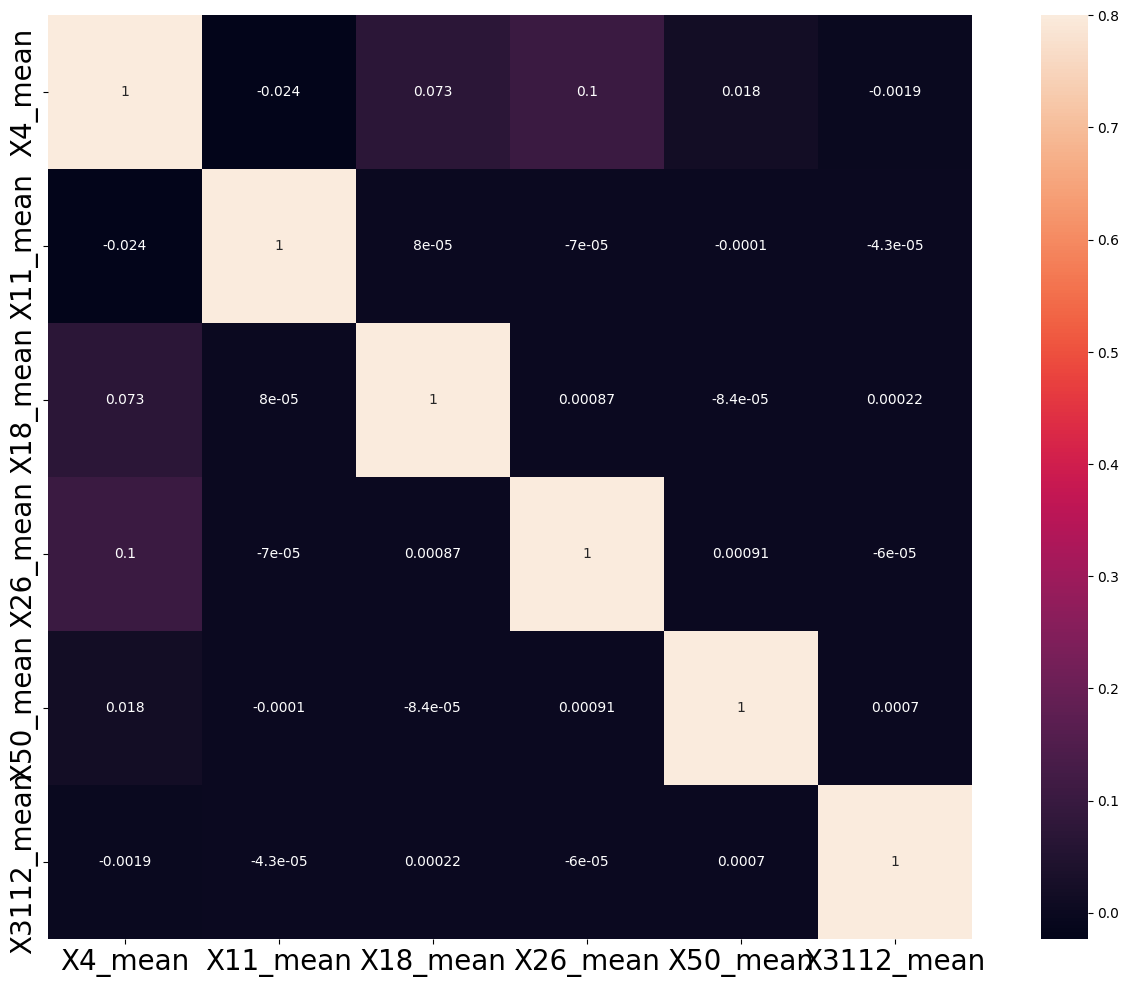

In [10]:
ax = plt.subplots(figsize=(18, 12))#调整画布大小
ax = sns.heatmap(corr, vmax=.8, square=True, annot=True)#画热力图   annot=True 表示显示系数
# 设置刻度字体大小
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


由热力图可以知道，变量之间并没有很强的相关性

# Config

In [11]:
# 定义Config类
class Config():
    IMAGE_SIZE = 384
    BACKBONE = 'swin_large_patch4_window12_384.ms_in22k_ft_in1k'
    TARGET_COLUMNS = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
    N_TARGETS = len(TARGET_COLUMNS)
    BATCH_SIZE = 10
    LR_MAX = 1e-4
    WEIGHT_DECAY = 0.01
    N_EPOCHS = 6
    TRAIN_MODEL = True
    IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
        
CONFIG = Config()

timm 是一个用于 PyTorch 的模型库，提供了大量的预训练图像模型和相关实用工具。swin_large_patch4_window12_384.ms_in22k_ft_in1k 是 Swin Transformer 模型的一个特定版本。

1. swin_large：指的是 Swin Transformer 模型的大版本（large）
2. patch4：表示模型将输入图像划分成 4x4 的小块（patch）来处理。
3. window12：表示模型使用 12x12 的窗口进行自注意力计算。
4. 384：表示模型的输入图像大小为 384x384 像素。
5. ms_in22k：表示模型首先在 ImageNet-22K 数据集上进行了多标签（multi-scale）预训练。
6. ft_in1k：表示模型随后在 ImageNet-1K 数据集上进行了微调（fine-tuning）。

Swin Transformer 是一种基于自注意力机制的视觉模型，它将输入图像划分为固定大小的小块，然后在这些小块的基础上进行层级处理。这种方法使得 Swin Transformer 在捕捉局部和全局图像信息方面非常高效，并且能够适应不同大小的输入图像。

* 预训练（ms_in22k）：在更大的 ImageNet-22K 数据集上进行预训练。ImageNet-22K 数据集包含约 14 亿个图像和 21,841 个类别。通过在这个大型数据集上预训练，模型能够学习到更加丰富和泛化的特征。

* 微调（ft_in1k）：在较小的 ImageNet-1K 数据集上进行微调。ImageNet-1K 数据集包含 1,000 个类别，常用于标准的图像分类任务。通过微调，模型能够更好地适应特定的任务需求。

# data -> pkl

In [12]:
train = pd.read_csv('/kaggle/input/planttraits2024/train.csv')
train['file_path'] = train['id'].apply(lambda s: f'/kaggle/input/planttraits2024/train_images/{s}.jpeg')
train['jpeg_bytes'] = train['file_path'].progress_apply(lambda fp: open(fp, 'rb').read())
train.to_pickle('train.pkl')

for column in CONFIG.TARGET_COLUMNS:
    lower_quantile = train[column].quantile(0.005)
    upper_quantile = train[column].quantile(0.985)  
    train = train[(train[column] >= lower_quantile) & (train[column] <= upper_quantile)]

CONFIG.N_TRAIN_SAMPLES = len(train)
CONFIG.N_STEPS_PER_EPOCH = (CONFIG.N_TRAIN_SAMPLES // CONFIG.BATCH_SIZE)
CONFIG.N_STEPS = CONFIG.N_STEPS_PER_EPOCH * CONFIG.N_EPOCHS + 1

test = pd.read_csv('/kaggle/input/planttraits2024/test.csv')
test['file_path'] = test['id'].apply(lambda s: f'/kaggle/input/planttraits2024/test_images/{s}.jpeg')
test['jpeg_bytes'] = test['file_path'].progress_apply(lambda fp: open(fp, 'rb').read())
test.to_pickle('test.pkl')

print('N_TRAIN_SAMPLES:', len(train), 'N_TEST_SAMPLES:', len(test))

  0%|          | 0/55489 [00:00<?, ?it/s]

  0%|          | 0/6545 [00:00<?, ?it/s]

N_TRAIN_SAMPLES: 49168 N_TEST_SAMPLES: 6545


# Standar

In [13]:
LOG_FEATURES = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

y_train = np.zeros_like(train[CONFIG.TARGET_COLUMNS], dtype=np.float32)
for target_idx, target in enumerate(CONFIG.TARGET_COLUMNS):
    v = train[target].values
    if target in LOG_FEATURES:
        v = np.log10(v)
    y_train[:, target_idx] = v

SCALER = StandardScaler()
y_train = SCALER.fit_transform(y_train)

In [14]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

TRAIN_TRANSFORMS = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomSizedCrop(
            [448, 512],
            CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE, w2h_ratio=1.0, p=0.75),
        A.Resize(CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.25),
        A.ImageCompression(quality_lower=85, quality_upper=100, p=0.25),
        A.ToFloat(),
        A.Normalize(mean=MEAN, std=STD, max_pixel_value=1),
        ToTensorV2(),
    ])

TEST_TRANSFORMS = A.Compose([
        A.Resize(CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE),
        A.ToFloat(),
        A.Normalize(mean=MEAN, std=STD, max_pixel_value=1),
        ToTensorV2(),
    ])

class Dataset(Dataset):
    def __init__(self, X_jpeg_bytes, y, transforms=None):
        self.X_jpeg_bytes = X_jpeg_bytes
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.X_jpeg_bytes)

    def __getitem__(self, index):
        X_sample = self.transforms(
            image=imageio.imread(self.X_jpeg_bytes[index]),
        )['image']
        y_sample = self.y[index]
        
        return X_sample, y_sample

train_dataset = Dataset(
    train['jpeg_bytes'].values,
    y_train,
    TRAIN_TRANSFORMS,
)

train_dataloader = DataLoader(
        train_dataset,
        batch_size=CONFIG.BATCH_SIZE,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
)

test_dataset = Dataset(
    test['jpeg_bytes'].values,
    test['id'].values,
    TEST_TRANSFORMS,
)

# Module

In [15]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
                CONFIG.BACKBONE,
                num_classes=CONFIG.N_TARGETS,
                pretrained=True)
        
    def forward(self, inputs):
        return self.backbone(inputs)

model = Model()
model = model.to('cuda')
print(model)

model.safetensors:   0%|          | 0.00/801M [00:00<?, ?B/s]

Model(
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=192, out_features=768, bias=

# Optimizer

In [16]:
def get_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=CONFIG.LR_MAX,
        total_steps=CONFIG.N_STEPS,
        pct_start=0.1,
        anneal_strategy='cos',
        div_factor=1e1,
        final_div_factor=1e1,
    )

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val):
        self.sum += val.sum()
        self.count += val.numel()
        self.avg = self.sum / self.count

MAE = torchmetrics.regression.MeanAbsoluteError().to('cuda')
R2 = torchmetrics.regression.R2Score(num_outputs=CONFIG.N_TARGETS, multioutput='uniform_average').to('cuda')
LOSS = AverageMeter()

Y_MEAN = torch.tensor(y_train).mean(dim=0).to('cuda')
EPS = torch.tensor([1e-6]).to('cuda')

def r2_loss(y_pred, y_true):
    ss_res = torch.sum((y_true - y_pred)**2, dim=0)
    ss_total = torch.sum((y_true - Y_MEAN)**2, dim=0)
    ss_total = torch.maximum(ss_total, EPS)
    r2 = torch.mean(ss_res / ss_total)
    return r2

LOSS_FN = nn.SmoothL1Loss() # r2_loss

optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=CONFIG.LR_MAX,
    weight_decay=CONFIG.WEIGHT_DECAY,
)

LR_SCHEDULER = get_lr_scheduler(optimizer)

平均绝对误差 MAE（Mean Absolute Error）：计算差值的绝对值：

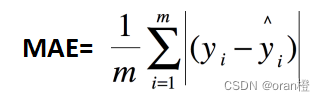

决定系数：R2（R-Square）：均值模型。我们知道一份数据集是有均值的，房价数据集有房价均值，学生成绩有成绩均值。现在我们把这个均值当成一个基准参照模型，也叫 baseline model。这个均值模型对任何数据的预测值都是一样的，可以想象该模型效果自然很差。基于此我们才会想从数据集中寻找规律，建立更好的模型。

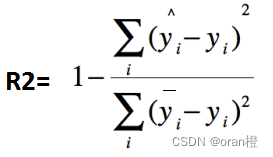

其中，分子部分表示真实值与预测值的平方差之和，类似于均方差 MSE；分母部分表示真实值与均值的平方差之和，类似于方差 Var。

R2-score =  1，达到最大值。即分子为 0 ，意味着样本中预测值和真实值完全相等，没有任何误差。也就是说我们建立的模型完美拟合了所有真实数据，是效果最好的模型，R2-score 值也达到了最大。

# Train

In [17]:
print("Start Training:")
for epoch in range(CONFIG.N_EPOCHS):
    MAE.reset()
    R2.reset()
    LOSS.reset()
    model.train()
        
    for step, (X_batch, y_true) in enumerate(train_dataloader):
        X_batch = X_batch.to('cuda')
        y_true = y_true.to('cuda')
        t_start = time.perf_counter_ns()
        y_pred = model(X_batch)
        loss = LOSS_FN(y_pred, y_true)
        LOSS.update(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        LR_SCHEDULER.step()
        MAE.update(y_pred, y_true)
        R2.update(y_pred, y_true)
            
        if not CONFIG.IS_INTERACTIVE and (step+1) == CONFIG.N_STEPS_PER_EPOCH:
            print(
                f'EPOCH {epoch+1:02d}, {step+1:04d}/{CONFIG.N_STEPS_PER_EPOCH} | ' + 
                f'loss: {LOSS.avg:.4f}, mae: {MAE.compute().item():.4f}, r2: {R2.compute().item():.4f}, ' +
                f'step: {(time.perf_counter_ns()-t_start)*1e-9:.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
            )
        elif CONFIG.IS_INTERACTIVE:
            print(
                f'\rEPOCH {epoch+1:02d}, {step+1:04d}/{CONFIG.N_STEPS_PER_EPOCH} | ' + 
                f'loss: {LOSS.avg:.4f}, mae: {MAE.compute().item():.4f}, r2: {R2.compute().item():.4f}, ' +
                f'step: {(time.perf_counter_ns()-t_start)*1e-9:.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
                end='\n' if (step + 1) == CONFIG.N_STEPS_PER_EPOCH else '', flush=True,
            )

torch.save(model, 'model.pth') 

Start Training:
EPOCH 01, 4916/4916 | loss: 0.2714, mae: 0.5974, r2: 0.3912, step: 1.338s, lr: 9.87e-05
EPOCH 02, 4916/4916 | loss: 0.2341, mae: 0.5438, r2: 0.4807, step: 1.243s, lr: 8.45e-05
EPOCH 03, 4916/4916 | loss: 0.1895, mae: 0.4787, r2: 0.5872, step: 1.243s, lr: 5.91e-05
EPOCH 04, 4916/4916 | loss: 0.1424, mae: 0.4056, r2: 0.6958, step: 1.242s, lr: 3.09e-05
EPOCH 05, 4916/4916 | loss: 0.1013, mae: 0.3362, r2: 0.7882, step: 1.241s, lr: 9.14e-06
EPOCH 06, 4916/4916 | loss: 0.0780, mae: 0.2928, r2: 0.8389, step: 1.243s, lr: 1.00e-06


In [18]:
SUBMISSION_ROWS = []
model.eval()

for X_sample_test, test_id in tqdm(test_dataset):
    with torch.no_grad():
        y_pred = model(X_sample_test.unsqueeze(0).to('cuda')).detach().cpu().numpy()
    
    y_pred = SCALER.inverse_transform(y_pred).squeeze()
    row = {'id': test_id}
    
    for k, v in zip(CONFIG.TARGET_COLUMNS, y_pred):
        if k in LOG_FEATURES:
            row[k.replace('_mean', '')] = 10 ** v
        else:
            row[k.replace('_mean', '')] = v

    SUBMISSION_ROWS.append(row)
    
submission_df = pd.DataFrame(SUBMISSION_ROWS)
submission_df.head()

submission_df.to_csv('submission.csv', index=False)
print("Submit!")


  0%|          | 0/6545 [00:00<?, ?it/s]

Submit!
